# 소개

해당 데이터셋은 러시아 온라인 쇼핑몰 회사의 매출 데이터입니다. 주어진 과제는 각 제품마다 매출을 예측하는 모델을 만드는 것입니다. 이 코드에서는 XGBoost라는 모델을 사용하였습니다.

과제는 회귀 분석 과제로 볼수 있으며, 이 코드에서도 XGBoostRegressor를 사용한것을 확인할수 있습니다.

한 가지 유의할 점은, 결과값의 범위가 [0, 20]이 되어야 한다는 점입니다.

처음에는 데이터를 로드합니다.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# 데이터 로드

In [2]:
# load data
items=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
cats=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
train=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

# 1. 데이터 정제

일단 이상치를 제거하고, 필요에 따라 새로운 항목을 추가합니다.

# 이상치 제거

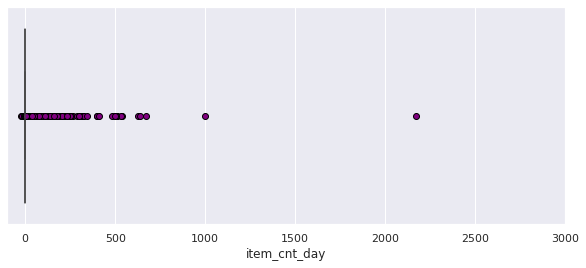

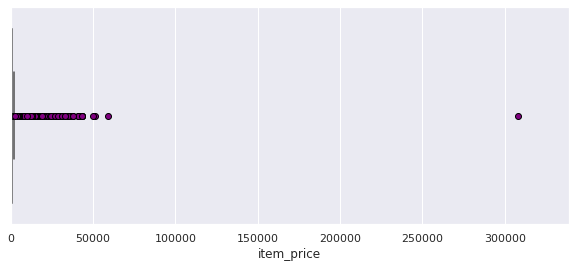

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

그래프를 확인하면, 대부분의 데이터는 item_cnt_day가 1000미만이고, item_price는 100000미만입니다. 그래프에서 확인되는 이상치는 해당 값들을 초과했습니다. 따라서 item_cnt_day와 item_price의 범위를 제한하여 이상치를 제거합니다.

다만 여기서는 item_price의 범위를 300000 미만으로 설정하였습니다.

In [4]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

음수값들은 제거합니다. (환불일수도 있습니다) item_price의 경우 아예 제거를 하고, item_cnt_day의 경우, 음수값들을 0으로 바꿉니다.

In [5]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

# 상점 데이터 정제

이름이 겹치는 상점들이 있습니다. 그럴 경우, 상점 아이디인 shop_id를 통일하면 됩니다. 이름이 겹치는 이유는 이사 등 여러가지 이유가 있을수 있습니다.

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

상점 데이터를 살펴보면, shop_name은 [도시 이름] [상점 카테고리] "상점 이름" 구조로 되어있습니다.

데이터 정제도 하게 되는데, 'Сергиев Посад ТЦ "7Я"' 의 경우 Сергиев Посад를 СергиевПосад로 (띄어쓰기 삭제)로 바꿉니다. 말씀드린것 처럼, Сергиев Посад는 러시아 도시 이름입니다. (https://ko.wikipedia.org/wiki/%EC%84%B8%EB%A5%B4%EA%B8%B0%EC%98%88%ED%94%84%ED%8F%AC%EC%82%AC%ED%8A%B8)


참고로 ТЦ는 Торговый центр의 약자인것으로 추측되고, 뜻은 영어로 Shopping mall입니다.


또한 "!Якутск"도 "Якутск"으로 바꿉니다. Якутск는 야쿠츠크 시입니다. (https://ko.wikipedia.org/wiki/%EC%95%BC%EC%BF%A0%EC%B8%A0%ED%81%AC)

In [7]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

카테고리의 경우, 5개 이상의 항목이 있는 카테고리만 유지합니다. 그렇지 않은 카테고리는 'other'로 바꿉니다.

In [8]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

도시 이름과 카테고리에 라벨엔코딩을 적용합니다. 그 결과, 도시 이름과 카테고리는 문자가 아닌 정수를 값으로 갖게 됩니다. shop_name은 더 이상 필요치 않으니 shops에서 제외됩니다.

In [9]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

# 제품 카테고리 데이터 정제

제품 카테고리도 데이터 정제가 필요합니다.

예를 들어, Игровые (Gaming) 과 Аксессуары (Accessories) 는 Игры (Games) 로 바꿉니다.

한 가지 눈여겨볼 점은, 게임기 악세서리, 예를 들어 컨트롤러 등도 Аксессуары 로 분류된다는 점입니다.

In [10]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

카테고리에 포함되는 데이터가 5개 미만이면 "etc"로 바꿉니다.

In [11]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

제품 카테고리 데이터를 살펴보면, [대분류] - [소분류] 식으로 되어있습니다.

따라서, -를 중심으로 문자를 나눈뒤, 대분류와 소분류 데이터에 각자 라벨인코딩을 수행합니다.

In [12]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

# 아이템 데이터 정제

아이템 데이터의 경우, 정규표현식을 이용해 데이터를 정제합니다.

1. 전부 소문자로 바꿉니다.
2. [ 괄호를 중심으로 분리한뒤, 앞의 부분만 남깁니다.
3. ( 괄호를 중심으로 분리한뒤, 앞의 부분만 남깁니다.
4. 문자나 숫자가 아니면 제거합니다. 특수문자들이 제거됩니다.
5. 두번 띄어쓴것은 한번 띄어쓴것으로 바꿉니다.
6. 앞뒤로 있는 빈칸은 제거합니다.

In [13]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

앞서 말한 데이터 정제 작업을 수행합니다.

[괄호나 (괄호로 분리하였을때, 뒷부분은 name2, name3로 따로 저장합니다. (앞부분은 name1로 저장합니다.)

괄호가 중요한 이유는, 제품 이름이 대부분 "게임 이름 [게임기]"나 "영화 이름 (블루레이나 DVD)" 등의 형식으로 이루어져 있기 때문입니다. **따라서 괄호 안의 데이터만 따로 모으는것이 이번 항목의 목표입니다.**

결측치는 0으로 바꿉니다.

In [14]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


한 가지 특이한 정제 작업이 있습니다. 엑스박스의 경우, "xbox 360"으로 저장되는 경우가 있는데, 만일 빈칸을 중심으로 분리한뒤 첫부분만 남긴다면, "xbox"만 남게 됩니다. 엑스박스는 여러 종류가 있어서, 이렇게 "xbox"만 남기는 것은 곤란합니다. 따라서 엑스박스 관련 데이터만 추가로 처리하게 됩니다.

참고로 해당 처리는 ()괄호 안에 있는 데이터에 적용되고, 따라서 name2 데이터를 정제하게 됩니다. 이렇게 정제한 name2 데이터는 type이라는 새로운 컬럼에 저장하게 됩니다.

type의 결측치는 mac으로 처리합니다.

In [15]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

type의 데이터에서 40개의 제품이 포함되지 않는 데이터를 drop_cols라는 배열에 저장합니다.

그런 다음, name2에서 drop_cols에 있는 데이터는 other로 바꿉니다.

마지막으로, type 컬럼을 삭제합니다.

In [16]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

name2와 name3에 라벨인코딩 작업을 수행합니다.

마지막으로, item_name과 name1은 삭제합니다.

In [17]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


# 데이터 전처리

매달 제품의 매출의 추이를 확인합니다.

여기서 date_block_num을 사용하게 되는데, 0부터 33까지 있습니다. 0은 2013년 1월, 1은 2013년 2월... 이런 식으로 구성되어 있습니다.

In [18]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

13.673473119735718

수익은 제품 가격과 제품 판매량을 곱하면 됩니다.

이렇게 구한 수익 데이터는 기존 데이터에 새로 추가합니다.

In [19]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

월 별로, 상점 별로, 그리고 상품 별로 판매량을 정렬합니다. 현재 판매량은 하루 기준으로 설정되어 있으니, 월 단위가 되게끔 합산을 합니다. 이렇게 구한 값은 item_cnt_month로 저장합니다.

In [20]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

5.577691078186035

가상의 데이터를 하나 만듭니다. 34번째 달의 데이터입니다.

In [21]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

훈련 데이터와 검증 데이터를 합칩니다. 

In [22]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.06251215934753418

이전에 처리했던 제품 데이터, 제품 카테고리 데이터, 상점 데이터 등도 합칩니다.

In [23]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

4.446821212768555

# 특성 공학

여기서 lag feature 라는 데이터를 추가합니다. 여기서 lag feature는 제품 판매 시점을 lags에서 지정한 값만큼 뒤로 바꿉니다. 예를 들어, lags가 [1, 2, 3] 이고 어떠한 제품이 0번째 달, 즉 2013년 1월에 판매되었다면, 해당 제품 판매 시점이 2013년 2월, 3월, 4월인 가공 데이터를 추가하게 됩니다.

In [24]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

item_cnt_month의 lag feature들을 추가합니다.

In [25]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


22.620421409606934

매달 판매량의 평균을 산출한 뒤, date_avg_item_cnt 피처로 추가합니다.

그런 다음, date_avg_item_cnt의 lag feature를 추가합니다.

마지막으로, date_avg_item_cnt를 삭제합니다.

In [26]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


12.449125528335571

위와 유사한 작업을 수행합니다.

한 가지 차이점은, 위에서는 단순 판매량만 계산했지만, 여기서는 각 제품마다 월 평균 판매량을 계산한다는 점입니다.

또 한가지 차이점은, lag feature 사용시, lags 인자가 [1, 2, 3] 이라는 것입니다. 이는 한달, 두달, 세달 후로 되어있는 가상 데이터를 추가하게 됩니다.

그 외에는 동일합니다.

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


29.33780837059021

이번에는 각 상점마다 월 평균 판매량을 계산합니다.

그 외에는 위와 동일합니다.

In [28]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


30.370939254760742

여기서는 각 상점, 각 제품의 월 평균 판매량을 계산합니다.

그 외에는 위와 동일합니다.

In [29]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


42.78661298751831

여기서는 각 상점, 각 subtype_code 별로 월 평균 판매량을 계산합니다.

여기서 subtype_code가 등장하는데, 데이터 정제 단계에서 제품 카테고리 부분을 참고하시면 됩니다. 간략히 설명하자면, 제품 카테고리는 원래 [대분류] - [소분류] 로 되어 있었는데, 분리 작업을 수행한뒤, [소분류] 부분을 라벨인코딩한 데이터가 subtype_code 입니다.

그 외에는 위와 동일합니다.

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


17.45894145965576

여기서는 각 도시의 월 평균 판매량을 계산합니다.

그 외에는 위와 동일합니다.

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


17.639882802963257

여기서는 각 제품, 각 도시의 월 평균 판매량을 계산합니다.

그 외에는 위와 동일합니다.

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


26.599640130996704

1. 각 제품의 평균 가격을 추산하고, 피처로 추가합니다.

2. 각 제품마다 월 평균 가격을 계산하고, 피처로 추가합니다. 그런 다음, 해당 피처의 lag feature를 추가합니다.

3. 각 월 평균 가격의 lag 마다 delta값을 계산합니다. delta값은 월 평균의 lag 값에 제품 평균 가격을 뺀 뒤, 제품 평균 가격으로 나눈 값입니다. delta값을 새로운 피처로 추가합니다. 

설명에 따르면, delta값을 분석해서 각 제품의 가격 변화 추이를 확인할수 있다고 합니다.

마지막으로, 1과 2에서 생성했던 피처들은 전부 삭제합니다.

In [33]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


412.7145595550537

1. 각 상점마다 월 총 수익을 계산한 뒤, 피처로 추가합니다.

2. 각 상점마다 평균 월을 계산합니다. (아직까지 해당 코드의 의도를 파악하지 못했습니다. 컬럼명을 봐서는 월 평균 수익을 계산해야 하는것 같습니다.) 

3. 각 월 총 수익의 delta 값을 계산하고, 피처로 추가합니다.

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

In [34]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


20.119709730148315

date_block_num을 월로 바꾼 피처인 month를 추가합니다. 다만 [1, 12]가 아니라 [0, 11]입니다. 그래서 0은 1월, 1은 2월... 이렇게 됩니다.

그리고 month의 각 월에 대응하는 날짜 갯수를 day라는 피처로 추가합니다. 예를 들어 0에는 31, 1에는 28 등..

In [35]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

각 상점, 각 제품마다 처음 팔린 날짜가 있을것입니다.

각 상점, 각 제품마다 제품 판매 날짜에 처음 팔린 날짜를 차감합니다.

각 제품에도 동일한 작업을 수행합니다.

In [36]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

2.021582841873169

마지막으로 첫 세달의 데이터를 삭제합니다. 삭제 이유는 lag feature가 없기 때문이라 합니다.

In [37]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

1.432976484298706

In [38]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


# Modelling

필요한 라이브러리를 불러옵니다. 여기서 XGBRegressor가 제일 중요한 라이브러리로 보입니다.

In [39]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

여기서 gc는 garbage collection입니다. del로 지운 데이터를 완전히 지움으로써 공간을 확보합니다.

In [40]:
data = matrix.copy()
del matrix
gc.collect()

49

In [41]:
data[data["date_block_num"]==34].shape

(214200, 33)

date_block_num이 34인 데이터를 검증 데이터로 지정합니다.

item_cnt_month가 y, 즉 타깃 데이터가 됩니다.

In [42]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

맨 앞에서 말씀드린것 처럼, 결과값의 범위는 [0, 20] 입니다.

따라서 clip() 함수를 사용해서 결과값의 범위를 조정합니다.

In [43]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [44]:
del data
gc.collect();

XGBRegressor를 사용하여 회귀 분석 작업을 수행합니다. 

패러미터를 잘 보시면, n_estimators가 1000, max_depth가 10인걸로 되어 있습니다. 모델 사이즈가 상당하다는 것을 추측할수 있습니다.

In [45]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[00:32:52] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18233	validation_1-rmse:1.11775
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12933	validation_1-rmse:1.07887
[2]	validation_0-rmse:1.08586	validation_1-rmse:1.04672
[3]	validation_0-rmse:1.04302	validation_1-rmse:1.01915
[4]	validation_0-rmse:1.01450	validation_1-rmse:0.99784
[5]	validation_0-rmse:0.98809	validation_1-rmse:0.98071
[6]	validation_0-rmse:0.96366	validation_1-rmse:0.96527
[7]	validation_0-rmse:0.93885	validation_1-rmse:0.95383
[8]	validation_0-rmse:0.92145	validation_1-rmse:0.94425
[9]	validation_0-rmse:0.90692	validation_1-rmse:0.93617
[10]	validation_0-rmse:0.89406	validation_1-rmse:0.92926
[11]	va

1673.7712862491608

In [46]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
print("RMSE: ", np.sqrt(mean_squared_error(Y_valid, Y_pred)))

RMSE:  0.89490587


XGBoost로 학습할때 어떤 피처들이 중요했는지 확인합니다.

5개의 중요한 피처는 다음과 같습니다.

1. delta_price_lag
2. item_id
3. date_block_num
4. item_cnt_month_lag_1
5. item_category_id

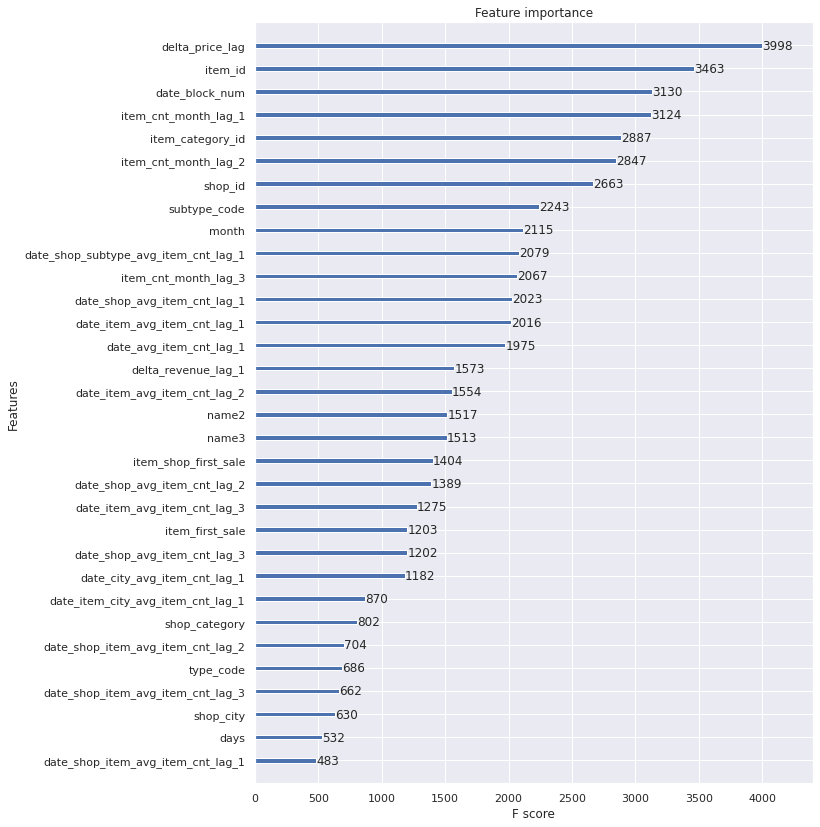

In [49]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

## LightGBM

LightGBM도 사용해보도록 하겠습니다.

In [50]:
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree
from sklearn.model_selection import cross_validate

In [56]:
ts = time.time()

lgbmr_model = LGBMRegressor(
    max_depth=5,
    n_estimators=2000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42
)

lgbmr_model.fit(X_train, Y_train,
               eval_metric='rmse',
               eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
                early_stopping_rounds = 20,
                verbose=False
              )

time.time() - ts

196.10912489891052

In [57]:
Y_pred = lgbmr_model.predict(X_valid).clip(0, 20)

print("RMSE: ", np.sqrt(mean_squared_error(Y_valid, Y_pred)))

RMSE:  0.8907938159393299


In [59]:
Y_test = lgbmr_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lgbm_submission.csv', index=False)

LightGBM으로 학습할때 어떤 피처들이 중요했는지 확인합니다.

5개의 중요한 피처는 다음과 같습니다.

1. date_item_avg_item_cnt_lag_1
2. item_cnt_month_lag_1
3. item_category_id
4. delta_price_lag
5. date_item_city_avg_item_cnt_lag_1

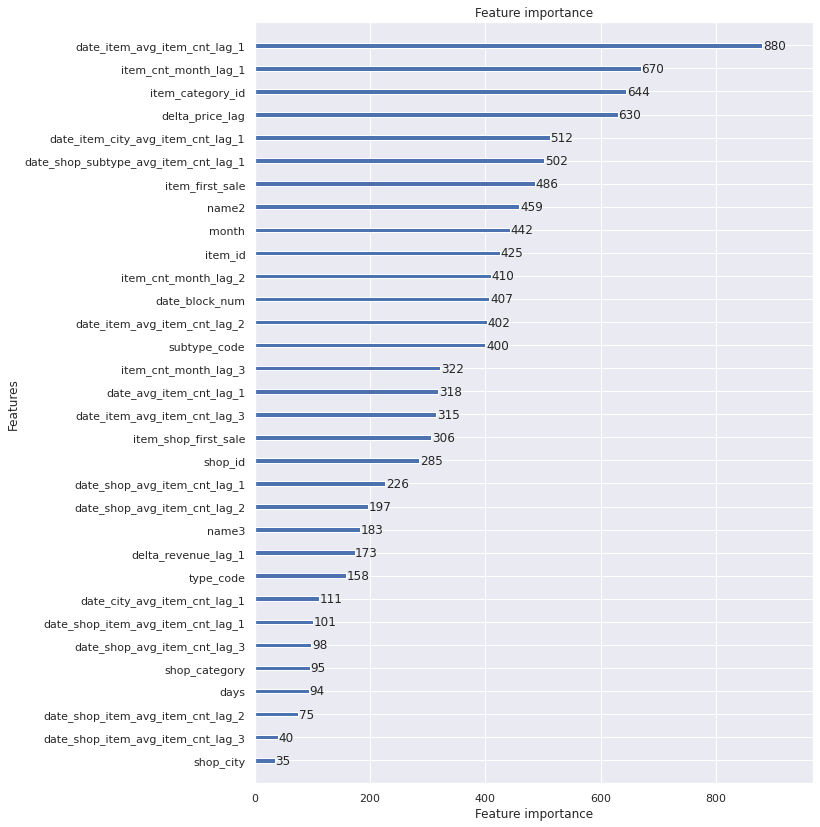

In [60]:
from lightgbm import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(lgbmr_model, (10,14))

## CatBoost

보통의 경우 CatBoost는 카테고리 분류에 사용되지만, CatBoost 라이브러리에서 회귀 모델인 CatBoostRegressor를 제공하기에, 실험삼아 한번 사용해 보았습니다.

In [61]:
from catboost import CatBoostRegressor

In [82]:
ts = time.time()

cat_model = CatBoostRegressor(
    loss_function='RMSE',
    max_depth=5,
    n_estimators=1000,
    colsample_bylevel=0.8, 
    subsample=0.8, 
    eta=0.1,
    random_seed=42
)

cat_model.fit(X_train, Y_train.astype('float'),
               eval_set=[(X_train, Y_train.astype('float')), (X_valid, Y_valid.astype('float'))],
                early_stopping_rounds = 20,
                verbose=False
              )

time.time() - ts

862.6725754737854

In [83]:
Y_pred = cat_model.predict(X_valid).clip(0, 20)

print("RMSE: ", np.sqrt(mean_squared_error(Y_valid, Y_pred)))

RMSE:  0.9001048413847487


In [84]:
Y_test = cat_model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('cat_submission.csv', index=False)

CatBoost로 학습할때 어떤 피처들이 중요했는지 확인합니다.

5개의 중요한 피처는 다음과 같습니다.

1. item_cnt_month_lag_1
2. item_first_sale
3. date_shop_item_avg_item_cnt_lag_1
4. date_item_avg_item_cnt_lag_1
5. item_category_id 

Text(0.5, 1.0, 'Feature Importance')

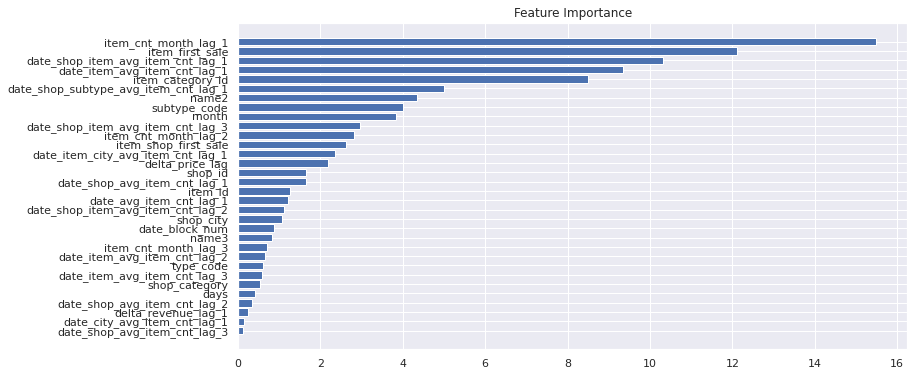

In [85]:
# CatBoost는 plot_importance를 따로 제공하지 않기에,
# 인터넷에서 따로 코드를 찾아서 복붙했습니다.
# 출처: https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-using-catboost


feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')